PCA-reduced data shape: (2880, 2)


Training Epochs: 100%|██████████| 10/10 [00:50<00:00,  5.07s/it, D Loss=0.0210, G Loss=5.3945]


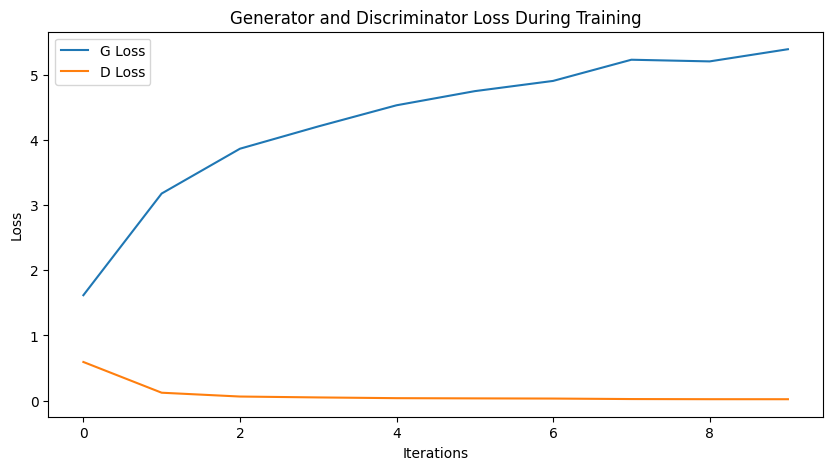

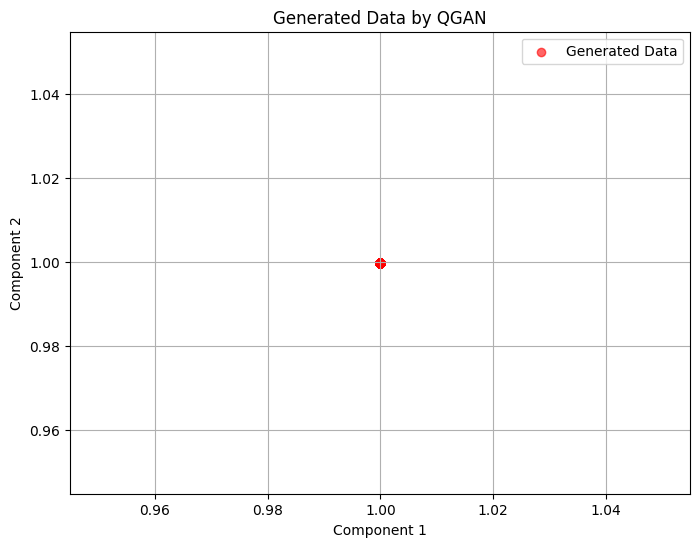

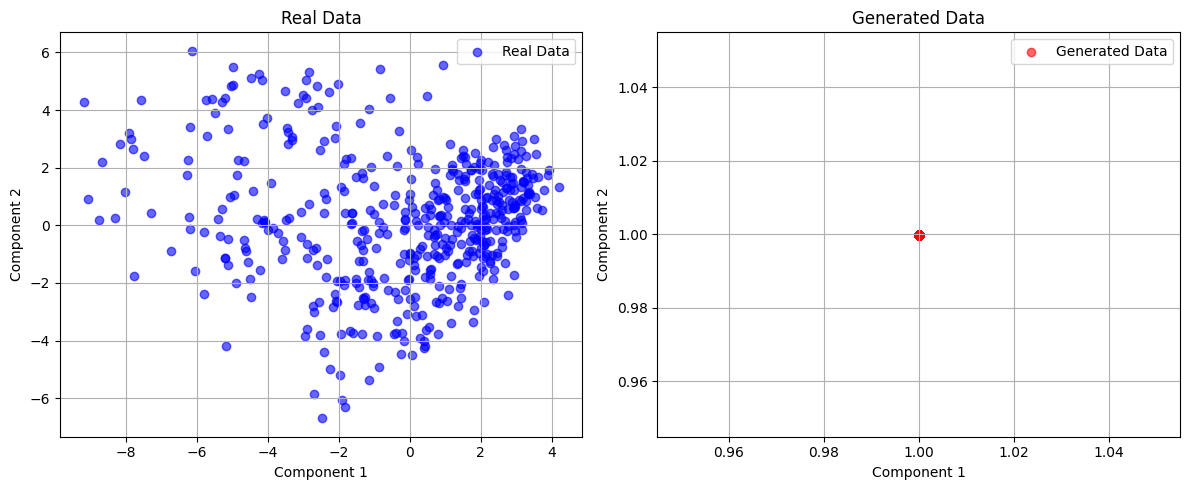

Discriminator Accuracy on Real Data: 99.40%
Discriminator Accuracy on Fake Data: 0.00%


In [9]:
import os
import numpy as np
import pennylane as qml
import torch
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from PIL import Image
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm  # Importing tqdm for progress bars


###############################################################################
# 1. Nepali MNIST Dataset
###############################################################################
class NepaliMNISTDataset(Dataset):
    """
    Custom dataset for Nepali numerals. Assumes root directory structure:
      root_dir/
      ├── 0/
      │   ├── image1.png
      │   └── ...
      ├── 1/
      │   ├── image1.png
      │   └── ...
      └── 9/
          ├── image1.png
          └── ...
    """
    def __init__(self, root_dir, transform=None):
        super().__init__()
        self.root_dir = root_dir
        self.transform = transform
        self.data_paths = []
        self.labels = []

        # Scanning directory for digit folders
        for label_str in sorted(os.listdir(root_dir)):
            label_path = os.path.join(root_dir, label_str)
            if not os.path.isdir(label_path):
                continue
            try:
                label = int(label_str)
            except ValueError:
                continue  # Skip non-integer directory names
            for img_name in os.listdir(label_path):
                if img_name.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp')):
                    self.data_paths.append(os.path.join(label_path, img_name))
                    self.labels.append(label)

    def __len__(self):
        return len(self.data_paths)

    def __getitem__(self, idx):
        img_path = self.data_paths[idx]
        label = self.labels[idx]
        img = Image.open(img_path).convert('L')  # ensure grayscale
        if self.transform:
            img = self.transform(img)
        return img, label


###############################################################################
# 2. Data Loading and Preprocessing
###############################################################################
def load_nepali_data(root_dir, batch_size=32):
    """
    Loads the Nepali MNIST dataset from the specified root directory.

    Args:
        root_dir (str): Path to the root directory containing digit folders.
        batch_size (int): Number of samples per batch.

    Returns:
        DataLoader: PyTorch DataLoader for the dataset.
    """
    # Basic transforms to resize to 28x28 and convert to tensor
    transform_pipeline = transforms.Compose([
        transforms.Resize((28, 28)),
        transforms.ToTensor()
    ])

    dataset = NepaliMNISTDataset(root_dir, transform=transform_pipeline)
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    return loader

def preprocess_data(loader, n_components=2):
    """
    Flattens images to vectors and applies PCA to reduce dimensionality.

    Args:
        loader (DataLoader): PyTorch DataLoader for the dataset.
        n_components (int): Number of PCA components.

    Returns:
        tuple: (PCA-reduced data, labels)
    """
    flattened_data = []
    labels = []
    for images, lbls in loader:
        # Ensure tensors are on CPU before converting to NumPy
        images = images.cpu()
        flattened_batch = images.view(images.size(0), -1).numpy()
        flattened_data.append(flattened_batch)
        labels.append(lbls.numpy())

    data_array = np.concatenate(flattened_data, axis=0)
    labels_array = np.concatenate(labels, axis=0)
    pca = PCA(n_components=n_components)
    data_pca = pca.fit_transform(data_array)
    return data_pca, labels_array  # shape: (num_samples, n_components), (num_samples,)


###############################################################################
# 3. Quantum Generator and Classical Discriminator
###############################################################################

# Define the number of qubits based on the PCA components
n_components = 2  # Number of features after PCA
n_qubits = 2       # Must be >= ceil(log2(n_components)) to accommodate all components

# Initialize PennyLane device for the quantum generator
dev = qml.device("default.qubit", wires=n_qubits)

def quantum_generator(params):
    """
    Quantum circuit acting as the generator.

    Args:
        params (list or np.ndarray): List of rotation parameters.

    Returns:
        list: Expectation values of PauliZ for each qubit.
    """
    for i in range(n_qubits):
        qml.RY(params[i], wires=i)  # Rotate each qubit

    # Entangle qubits
    for i in range(n_qubits - 1):
        qml.CNOT(wires=[i, i + 1])

    # Measurement: Expectation values of PauliZ for each qubit
    return [qml.expval(qml.PauliZ(wire)) for wire in range(n_qubits)]

# Define the QNode
@qml.qnode(dev)
def generator_circuit(params):
    """
    PennyLane QNode that runs the quantum generator circuit.

    Args:
        params (list or np.ndarray): List of rotation parameters.

    Returns:
        list: Expectation values of PauliZ for each qubit.
    """
    return quantum_generator(params)

# Define the Classical Discriminator using PyTorch
class Discriminator(nn.Module):
    """
    Classical Discriminator network using PyTorch.

    Args:
        input_dim (int): Dimension of the input data.
    """
    def __init__(self, input_dim=2):  # input_dim should match n_qubits
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 16),
            nn.ReLU(),
            nn.Linear(16, 8),
            nn.ReLU(),
            nn.Linear(8, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        """
        Forward pass of the discriminator.

        Args:
            x (torch.Tensor): Input tensor.

        Returns:
            torch.Tensor: Output tensor after passing through the network.
        """
        return self.model(x)


###############################################################################
# 4. Quantum Generator Class Integrating Quantum Circuit with PyTorch
###############################################################################

class QuantumGenerator(nn.Module):
    """
    Quantum Generator network integrating a quantum circuit with PyTorch.

    Args:
        n_qubits (int): Number of qubits in the quantum circuit.
        verbose (bool): Flag to enable/disable debug print statements.
    """
    def __init__(self, n_qubits, verbose=False):
        super(QuantumGenerator, self).__init__()
        self.n_qubits = n_qubits
        self.verbose = verbose
        # Initialize generator parameters (weights)
        # Requires gradient computation
        self.params = nn.Parameter(0.01 * torch.randn(n_qubits))

    def forward(self):
        """
        Forward pass of the quantum generator.

        Returns:
            torch.Tensor: Generated data as a tensor.
        """
        # Convert parameters to NumPy for PennyLane
        params = self.params.detach().numpy()
        # Get generator output from quantum circuit
        generated_data = generator_circuit(params)
        
        # Debugging: Print the type and content of generated_data
        if self.verbose:
            print(f"Generated Data (before conversion): {generated_data}, Type: {type(generated_data)}")
        
        # Ensure generated_data is a list with n_qubits elements
        if not isinstance(generated_data, (list, np.ndarray)):
            raise TypeError(f"Expected list or np.ndarray from generator_circuit, got {type(generated_data)}")
        if len(generated_data) != self.n_qubits:
            raise ValueError(f"Expected {self.n_qubits} generated values, got {len(generated_data)}")
        
        # Convert list of tensors or floats to list of floats
        generated_data = [x.item() if isinstance(x, torch.Tensor) else float(x) for x in generated_data]
        
        # Convert list of floats to torch tensor
        generated_data = torch.tensor(generated_data, dtype=torch.float32)
        
        # Debugging: Print the stacked generated data
        if self.verbose:
            print(f"Stacked Generated Data: {generated_data}, Shape: {generated_data.shape}")
        
        return generated_data


###############################################################################
# 5. Training the QGAN
###############################################################################

def train_qgan(loader, epochs=1000, lr=0.01, verbose=False):
    """
    Trains the Quantum Generative Adversarial Network (QGAN).

    Args:
        loader (DataLoader): DataLoader for the training data.
        epochs (int): Number of training epochs.
        lr (float): Learning rate for optimizers.
        verbose (bool): Flag to enable/disable debug print statements.

    Returns:
        tuple: (Trained Generator, Trained Discriminator, Generator Losses, Discriminator Losses)
    """
    # Initialize Generator and Discriminator
    generator = QuantumGenerator(n_qubits, verbose=verbose)
    discriminator = Discriminator(input_dim=n_components)

    # Optimizers
    optimizer_G = optim.Adam(generator.parameters(), lr=lr)
    optimizer_D = optim.Adam(discriminator.parameters(), lr=lr)

    # Loss function
    criterion = nn.BCELoss()

    # Labels
    real_label = 1.
    fake_label = 0.

    # Lists to keep track of progress
    G_losses = []
    D_losses = []

    # Using tqdm for progress bars
    epoch_iterator = tqdm(range(epochs), desc="Training Epochs")

    for epoch in epoch_iterator:
        epoch_losses_G = []
        epoch_losses_D = []
        for data, _ in loader:
            batch_size = data.size(0)

            # =====================
            # Train Discriminator
            # =====================
            discriminator.zero_grad()
            # Real data
            real_data = data.view(batch_size, -1)
            output_real = discriminator(real_data)
            labels_real = torch.full((batch_size, 1), real_label)
            loss_real = criterion(output_real, labels_real)
            loss_real.backward()

            # Fake data
            fake_data = []
            for _ in range(batch_size):
                fake_sample = generator()
                fake_data.append(fake_sample)
            fake_data = torch.stack(fake_data).detach()
            output_fake = discriminator(fake_data)
            labels_fake = torch.full((batch_size, 1), fake_label)
            loss_fake = criterion(output_fake, labels_fake)
            loss_fake.backward()

            # Update Discriminator
            optimizer_D.step()

            # =====================
            # Train Generator
            # =====================
            generator.zero_grad()
            fake_data = []
            for _ in range(batch_size):
                fake_sample = generator()
                fake_data.append(fake_sample)
            fake_data = torch.stack(fake_data)
            output_fake = discriminator(fake_data)
            labels_gen = torch.full((batch_size, 1), real_label)  # Generator tries to fool discriminator
            loss_gen = criterion(output_fake, labels_gen)
            loss_gen.backward()
            optimizer_G.step()

            # Record losses
            epoch_losses_G.append(loss_gen.item())
            epoch_losses_D.append((loss_real + loss_fake).item())

        # Calculate average losses for the epoch
        avg_loss_G = np.mean(epoch_losses_G)
        avg_loss_D = np.mean(epoch_losses_D)
        G_losses.append(avg_loss_G)
        D_losses.append(avg_loss_D)

        # Update tqdm description
        epoch_iterator.set_postfix({'D Loss': f"{avg_loss_D:.4f}", 'G Loss': f"{avg_loss_G:.4f}"})

    return generator, discriminator, G_losses, D_losses


###############################################################################
# 6. Visualization of Generated Data
###############################################################################

def visualize_generated_data(generator, num_samples=100):
    """
    Visualizes the data generated by the generator.

    Args:
        generator (QuantumGenerator): Trained quantum generator.
        num_samples (int): Number of samples to generate for visualization.
    """
    generator.eval()
    with torch.no_grad():
        generated_samples = []
        for _ in range(num_samples):
            sample = generator().numpy()
            generated_samples.append(sample)
    generated_samples = np.array(generated_samples)

    # Plot generated data
    plt.figure(figsize=(8, 6))
    plt.scatter(generated_samples[:, 0], generated_samples[:, 1], c='red', label='Generated Data', alpha=0.6)
    plt.title("Generated Data by QGAN")
    plt.xlabel("Component 1")
    plt.ylabel("Component 2")
    plt.legend()
    plt.grid(True)
    plt.show()


###############################################################################
# 7. Evaluating QGAN Performance
###############################################################################

def evaluate_qgan(generator, discriminator, loader, num_samples=100):
    """
    Evaluates the performance of the trained QGAN.

    Args:
        generator (QuantumGenerator): Trained quantum generator.
        discriminator (Discriminator): Trained classical discriminator.
        loader (DataLoader): DataLoader for real data.
        num_samples (int): Number of samples to evaluate.
    """
    generator.eval()
    discriminator.eval()
    with torch.no_grad():
        # Generate fake data
        fake_data = []
        for _ in range(num_samples):
            sample = generator().numpy()
            fake_data.append(sample)
        fake_data = np.array(fake_data)

        # Get real data
        real_data = []
        for data, _ in loader:
            data = data.view(data.size(0), -1).numpy()
            real_data.append(data)
            if len(real_data) * data.shape[0] >= num_samples:
                break
        real_data = np.concatenate(real_data, axis=0)[:num_samples]

        # Plot comparison
        plt.figure(figsize=(12, 5))

        plt.subplot(1, 2, 1)
        plt.scatter(real_data[:, 0], real_data[:, 1], c='blue', label='Real Data', alpha=0.6)
        plt.title("Real Data")
        plt.xlabel("Component 1")
        plt.ylabel("Component 2")
        plt.legend()
        plt.grid(True)

        plt.subplot(1, 2, 2)
        plt.scatter(fake_data[:, 0], fake_data[:, 1], c='red', label='Generated Data', alpha=0.6)
        plt.title("Generated Data")
        plt.xlabel("Component 1")
        plt.ylabel("Component 2")
        plt.legend()
        plt.grid(True)

        plt.tight_layout()
        plt.show()

        # Evaluate Discriminator on Real and Fake Data
        real_labels = torch.ones((num_samples, 1))
        fake_labels = torch.zeros((num_samples, 1))
        real_preds = discriminator(torch.tensor(real_data, dtype=torch.float32))
        fake_preds = discriminator(torch.tensor(fake_data, dtype=torch.float32))

        real_acc = ((real_preds > 0.5).float() == real_labels).sum().item() / num_samples
        fake_acc = ((fake_preds < 0.5).float() == fake_labels).sum().item() / num_samples

        print(f'Discriminator Accuracy on Real Data: {real_acc * 100:.2f}%')
        print(f'Discriminator Accuracy on Fake Data: {fake_acc * 100:.2f}%')


###############################################################################
# 8. Main Function to Demonstrate QGAN
###############################################################################

def main():
    """
    Main function to execute the QGAN training and evaluation.
    """
    # Update the root_dir to your dataset path
    root_dir = "/Users/sahajrajmalla/Documents/nepali-quantum-mnist/data/numerals"  # <-- Replace with your actual dataset path
    loader = load_nepali_data(root_dir, batch_size=32)

    # Preprocess data
    data_pca, labels = preprocess_data(loader, n_components=n_components)
    print("PCA-reduced data shape:", data_pca.shape)

    # Convert data to torch tensors
    data_pca_tensor = torch.tensor(data_pca, dtype=torch.float32)
    labels_tensor = torch.tensor(labels, dtype=torch.long)

    # Create a new DataLoader for QGAN training
    dataset_pca = torch.utils.data.TensorDataset(data_pca_tensor, labels_tensor)
    loader_pca = DataLoader(dataset_pca, batch_size=32, shuffle=True)

    # Train QGAN
    epochs = 10  # Adjust as needed default(1000)
    lr = 0.01
    generator, discriminator, G_losses, D_losses = train_qgan(loader_pca, epochs=epochs, lr=lr, verbose=False)

    # Plot training losses
    plt.figure(figsize=(10,5))
    plt.title("Generator and Discriminator Loss During Training")
    plt.plot(G_losses, label="G Loss")
    plt.plot(D_losses, label="D Loss")
    plt.xlabel("Iterations")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

    # Visualize generated data
    visualize_generated_data(generator, num_samples=500)

    # Evaluate QGAN performance
    evaluate_qgan(generator, discriminator, loader_pca, num_samples=500)


if __name__ == "__main__":
    main()
